In [22]:
%matplotlib inline
import numpy as np
import os
from datavyz import ge

# Simulations with synaptic mechanisms only

The data are generated by looping over:

    - background activity levels
    - seeds for the background activity
    - stimulus intensity (the number of synapses recruited)
    - the stimulus properties (here the seed that shape the random synaptic sequence).

This loop over four conditions is implemented in the bash script: [./bash/BG.sh](./bash/BG.sh)

You can run it with:

> sh bash/BG.sh

## Raw responses

### Load data from individual sims (i.e. one specific background seed, one specific stimulus seed)

In [23]:
%run bash/load_batch_simulations.py
RESP_PASSIVE = build_full_dataset(key='passive',
                                  folder = os.path.join('data', 'bg-modul'),
                                  filename_only=True)

In [24]:
# plotting function in script:
%run plots/plot_single_sim_bg_data.py

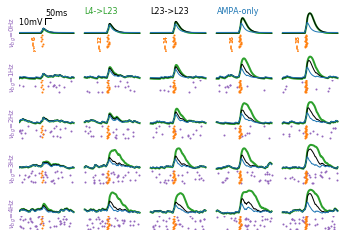

In [25]:
props = {'NSTIMs':[6,12,14,16,18],
         'alphaZn':[0., 0.45],
         'syn_location':1, 'stimseeds':[1], 'seeds':[0],
         'with_ampa_only':True,
         'LWS':[2,1,1], 'COLORS':[ge.green, 'k'],
         'LABELS':['L4->L23', 'L23->L23', 'AMPA-only'],
         'bar_scale_args':dict(Xbar = 50, Xbar_label='50ms', Ybar = 10, Ybar_label='10mV ', loc=(0.08,0.6), orientation='right-bottom'),
         'figsize':(2.3,.1), 'view':[-200,300], 'shift':100, 'VLIM':[-76,-30]}
fig = plot_single_sim_bg_data(RESP_PASSIVE, ge,
                              bg_levels=[0,1,2,3,4], **props)
#fig.savefig(os.path.join('figures', 'bg-dep-passive-full-example-single-trial.png'), dpi=300)
fig.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', 'B.svg'))

#### shifting synaptic locations and seeds (background & stimulus)

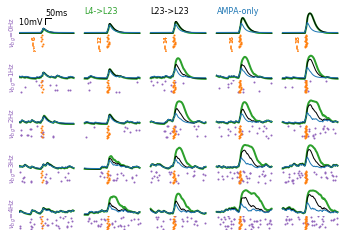

In [26]:
props['syn_location'] = 2
props['stimseeds'] = [1]
props['seeds'] = [2]
fig = plot_single_sim_bg_data(RESP_PASSIVE, ge,
                              bg_levels=[0,1,2,3,4], **props)

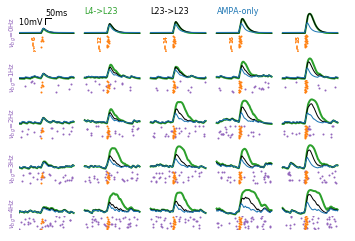

In [27]:
props['syn_location'] = 5
props['stimseeds'] = [2]
props['seeds'] = [7]
fig = plot_single_sim_bg_data(RESP_PASSIVE, ge,
                              bg_levels=[0,1,2,3,4], **props)

### Average data (from multiple synaptic locations, background activity and stimulus identity)

In [28]:
%run bash/load_batch_simulations.py
RESP_PASSIVE_PER_STIM = build_full_dataset_per_stim(key='passive',
                                                    with_Vm_trace=True,
                                                    folder = os.path.join('data', 'bg-modul'),
                                                    filename_only=True)

<Figure size 432x288 with 0 Axes>

### Synaptic location 1

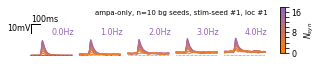

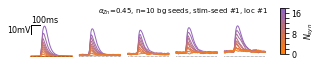

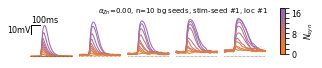

In [29]:
%run plots/show_trial_average_responses.py
props = {'VLIM':[-76,-30], 'syn_location':1, 'stimseed':10, 'window':[-100,350], 'annotate':True}
fig1=show_trial_average_responses(RESP_PASSIVE_PER_STIM,'ampa-only',**props)
props['annotate'] = False
fig2=show_trial_average_responses(RESP_PASSIVE_PER_STIM,alphaZn=0.45,**props)
fig3=show_trial_average_responses(RESP_PASSIVE_PER_STIM,alphaZn=0.,**props)

In [30]:
ge.multipanel_figure([[fig1],[fig2],[fig3]], LABELS=[['a'],['b'],['c']],
                     X=[[-10], [-10], [-10]], Y=[[-5], [60], [120]],
                     Y_LABELS=[[0], [60], [120]], X_LABELS=[[0], [0], [0]],
                     width='one-and-a-half-column', export_to_png=True,
                     height=67, fig_name='figures/bg-trial-average.svg')

RUNNING: inkscape figures/bg-trial-average.svg --export-area-page --export-background="white" --export-type=png --export-filename="figures/bg-trial-average.png" --export-dpi=300
[ok] figure successfully exported as: figures/bg-trial-average.png


### Synaptic location 2

(N.B. the waveforms are close to identical because we average over the same background and stimulus seeds, the synaptic locations will therefore only vary the amplitude of the waveform but not so muchits temporal profile)

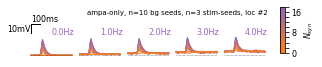

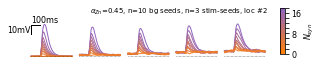

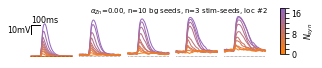

In [31]:
props={'VLIM':[-76,-33],'syn_location':2,'window':[-100,350],'annotate':True}
fig1=show_trial_average_responses(RESP_PASSIVE_PER_STIM,'ampa-only',**props)
props['annotate'] = False
fig2=show_trial_average_responses(RESP_PASSIVE_PER_STIM,alphaZn=0.45,**props)
fig3=show_trial_average_responses(RESP_PASSIVE_PER_STIM,alphaZn=0.,**props)

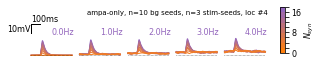

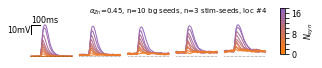

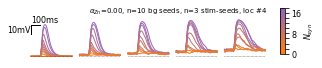

In [32]:
props={'VLIM':[-76,-33],'syn_location':4,'window':[-100,350],'annotate':True}
fig1=show_trial_average_responses(RESP_PASSIVE_PER_STIM,'ampa-only',**props)
props['annotate'] = False
fig2=show_trial_average_responses(RESP_PASSIVE_PER_STIM,alphaZn=0.45,**props)
fig3=show_trial_average_responses(RESP_PASSIVE_PER_STIM,alphaZn=0.,**props)

### Computing input-ouput curves ()

Text(0.5, 0.98, '\n                              syn loc. #1')

<Figure size 432x288 with 0 Axes>

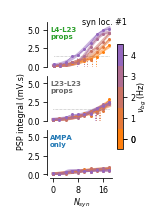

In [33]:
%run plots/show_trial_average_responses.py
props = {'syn_location':1, 'thresholds':{'Integral':1.5}} # 'VLIM':[-76,0], 
AMPA = get_trial_average_responses(RESP_PASSIVE_PER_STIM, 'ampa-only', **props)
FREE = get_trial_average_responses(RESP_PASSIVE_PER_STIM,  alphaZn=0.45, **props)
CHELATED = get_trial_average_responses(RESP_PASSIVE_PER_STIM,  alphaZn=0., **props)
fig1 = show_response_bg_dep(FREE, CHELATED, AMPA,
                            method='Integral', ge=ge,
                            ylim=[-0.1,6], yscale='lin',
                            crossing=props['thresholds']['Integral'])
fig1.suptitle('\n'+30*' '+'syn loc. #%i' % props['syn_location'], size=8)

Text(0.5, 0.98, '\n                              syn loc. #4')

<Figure size 432x288 with 0 Axes>

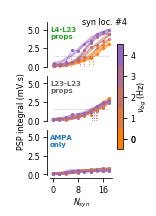

In [34]:
%run plots/show_trial_average_responses.py
props = {'syn_location':4, 'thresholds':{'Integral':1.5}} # 'VLIM':[-76,0], 
AMPA = get_trial_average_responses(RESP_PASSIVE_PER_STIM, 'ampa-only', **props)
FREE = get_trial_average_responses(RESP_PASSIVE_PER_STIM,  alphaZn=0.45, **props)
CHELATED = get_trial_average_responses(RESP_PASSIVE_PER_STIM,  alphaZn=0., **props)
fig2 = show_response_bg_dep(FREE, CHELATED, AMPA,
                                method='Integral', ge=ge,
                                ylim=[-0.1,6], yscale='lin',
                                crossing=props['thresholds']['Integral'])
fig2.suptitle('\n'+30*' '+'syn loc. #%i' % props['syn_location'], size=8)

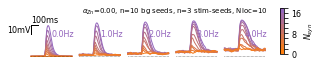

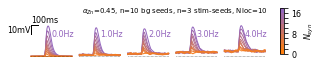

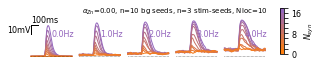

In [35]:
props = {'VLIM':[-76,-33], 'syn_location':'all'}
show_trial_average_responses(RESP_PASSIVE_PER_STIM, alphaZn=0.45, **props)
show_trial_average_responses(RESP_PASSIVE_PER_STIM, alphaZn=0., **props)

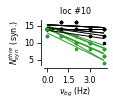

In [65]:
SLOPES = {'free':[], 'chelated':[]}
fig, ax= ge.figure()
for i in np.unique(RESP_PASSIVE_PER_STIM['syn_location']):
    props = {'syn_location':i, 'thresholds':{'Integral':1.5}}
    FREE=get_trial_average_responses(RESP_PASSIVE_PER_STIM, alphaZn=0.45, **props)
    CHELATED=get_trial_average_responses(RESP_PASSIVE_PER_STIM, alphaZn=0., **props)
    for C, color, key in zip([FREE, CHELATED],
                             ['k', ge.green], ['free', 'chelated']):
        x = [C[i]['bg_level'] for i in range(len(C))]
        y = [C[i]['Integral-threshold'] for i in range(len(C))]
        lin = np.polyfit(x, y, 1)
        SLOPES[key].append(-lin[0])
        ge.scatter(x, y, color=color, ax=ax, no_set=True)
        ge.plot(x, np.polyval(lin, x), color=color, ax=ax, no_set=True)
        ge.title(ax, 'loc #%i' % i)
ge.set_plot(ax,
            ylabel='$N_{syn}^{thre}$ (syn.)',
            xlabel='$\\nu_{bg}$ (Hz)')

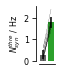

In [70]:
fig3, ax, pval = ge.related_samples_two_conditions_comparison(np.array(SLOPES['free']),
                                                              np.array(SLOPES['chelated']),
                                                                   with_annotation=False,
                                                                   lw=.2,
                                                                   color1=ge.dimgrey, color2=ge.green,
                                                                   ylabel='$N_{syn}^{thre}$ / Hz',
                                                                   xticks=[],#[0, 1],
                                                                   fig_args=dict(right=4., 
                                                                    figsize=(.5,1.2), left=1.2, top=1.5))
#ge.annotate(ax, 'thresh. shift', (1., 1.1), ha='right')
#ge.annotate(ax, 'n=%i loc.' % len(SLOPES['free']) , (-.6, -.4))

'%.1f$\pm$%.1f, %.1f$\pm$%.1f' %(np.mean(SLOPES['free']), np.std(SLOPES['free']), np.mean(SLOPES['chelated']), np.std(SLOPES['chelated']))
from scipy.stats import wilcoxon
wilcoxon(SLOPES['free'], SLOPES['chelated'])
fig3.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', 'Fi.svg'))

## Quantifying stimulus encoding (independently and across the background activity levels)

In [38]:
from sklearn.neighbors import NearestNeighbors

def build_training_set(RESP_PER_STIM, resp='ampa-only',
                       stimseed='all',
                       N=None, # useless
                       bg_level='all',
                       syn_location='all',
                       verbose=True,
                       window=[-100, 300]):
    if resp=='ampa-only':
        cond = (RESP_PER_STIM['ampa_only']==True)
    elif resp=='L23':
        cond = (RESP_PER_STIM['ampa_only']==False) & (RESP_PER_STIM['alphaZn']==0.45)
    elif resp=='L4':
        cond = (RESP_PER_STIM['ampa_only']==False) & (RESP_PER_STIM['alphaZn']==0.)
        
    if bg_level!='all':
        cond = cond & (RESP_PER_STIM['bg_level']==bg_level)
    if syn_location!='all':
        cond = cond & (RESP_PER_STIM['syn_location']==syn_location)
    if stimseed!='all':
        cond = cond & (RESP_PER_STIM['stimseed']==stimseed)
        
    nstims = np.unique(RESP_PER_STIM['nstim'][cond])

    tcond = (RESP_PASSIVE_PER_STIM['t']>RESP_PASSIVE_PER_STIM['stim_delay']+window[0]) &\
        (RESP_PASSIVE_PER_STIM['t']<RESP_PASSIVE_PER_STIM['stim_delay']+window[1])
    
    Vm_traces = []
    for i, nstim in enumerate(nstims):
        cond1 = cond & (RESP_PER_STIM['nstim']==nstim)
        Vm_traces.append(np.mean(RESP_PASSIVE_PER_STIM['Vm'][cond1]-np.mean(RESP_PER_STIM['Vm_baseline'][cond1]), axis=0)[tcond])

    return Vm_traces


def build_test_set(RESP_PER_STIM, resp='ampa-only',
                   N=100,
                   stimseed='all',
                   bg_level='all',
                   syn_location='all',
                   window=None, verbose=True):
    
    if resp=='ampa-only':
        cond = (RESP_PER_STIM['ampa_only']==True)
    elif resp=='L23':
        cond = (RESP_PER_STIM['ampa_only']==False) & (RESP_PER_STIM['alphaZn']==0.45)
    elif resp=='L4':
        cond = (RESP_PER_STIM['ampa_only']==False) & (RESP_PER_STIM['alphaZn']==0.)
        
    if stimseed!='all':
        cond = cond & (RESP_PER_STIM['stimseed']==stimseed)
    if bg_level!='all':
        cond = cond & (RESP_PER_STIM['bg_level']==bg_level)

    Vm_traces, true_ID = [], []
    tcond = (RESP_PASSIVE_PER_STIM['t']>RESP_PASSIVE_PER_STIM['stim_delay']+window[0]) &\
        (RESP_PASSIVE_PER_STIM['t']<RESP_PASSIVE_PER_STIM['stim_delay']+window[1])
    
    if syn_location!='all':
        
        cond = cond & (RESP_PER_STIM['syn_location']==syn_location)
        nstims = np.sort(np.unique(RESP_PER_STIM['nstim'][cond]))
        icond = np.arange(len(RESP_PER_STIM['nstim']))[cond]

        if len(icond)<N:
            N = len(icond)
            if verbose:
                print('N=', N)

        for n, i in enumerate(np.random.choice(icond, N, replace=False)):
            
           true_ID.append(np.argwhere(RESP_PER_STIM['nstim'][i]==nstims)[0][0])
           Vm_traces.append(RESP_PER_STIM['Vm'][i][tcond]-RESP_PER_STIM['Vm_baseline'][i])
    else:
        syn_locations = np.unique(RESP_PER_STIM['syn_location'])
        nstims = np.sort(np.unique(RESP_PER_STIM['nstim'][cond]))
        i=0
        # we force that a single realisation has the sum of all location
        while i<N:
            ns = np.random.choice(nstims, 1) # we pick a given level
            vm_trace = []
            for s in syn_locations:
                cond1 = cond & (RESP_PER_STIM['syn_location']==s) & (RESP_PER_STIM['nstim']==ns)
                i0 = np.random.choice(np.arange(len(RESP_PER_STIM['nstim']))[cond1], 1)[0]
                vm_trace.append(RESP_PER_STIM['Vm'][i0][tcond]-RESP_PER_STIM['Vm_baseline'][i0])
                
            true_ID.append(np.argwhere(ns==nstims)[0][0])
            Vm_traces.append(np.mean(vm_trace, axis=0))
            i+=1
        
    return Vm_traces, true_ID

def compute_decoding_accuracy(RESP_PASSIVE_PER_STIM, props,
                              verbose=False):
    
    Vm_traces_training = build_training_set(RESP_PASSIVE_PER_STIM, **props)
    nbrs = NearestNeighbors(n_neighbors=1,
                            algorithm='brute', metric='euclidean').fit(Vm_traces_training)
    Vm_traces_test, test_ID = build_test_set(RESP_PASSIVE_PER_STIM, **props)

    _, pred = nbrs.kneighbors(Vm_traces_test)
    val = test_ID-pred.flatten()
    if verbose:
        print('For the properties %s' % props)
        print('--> Decoder accuracy: %.2f %%    (chance level= %.0f%%)' % (100*np.sum(val==0)/len(val), 100/len(Vm_traces_training)))
    return 100*np.sum(val==0)/len(val)


props = {'bg_level':'all',
         'syn_location':3,
         'stimseed':30,
         'resp':'L23',
         'window':[-100, 300],
         'N':200}
compute_decoding_accuracy(RESP_PASSIVE_PER_STIM, props, verbose=True)


For the properties {'bg_level': 'all', 'syn_location': 3, 'stimseed': 30, 'resp': 'L23', 'window': [-100, 300], 'N': 200}
--> Decoder accuracy: 61.50 %    (chance level= 10%)


61.5

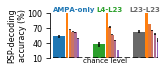

In [39]:
props = {'bg_level':'all',
         'syn_location':1,
         'stimseed':'all',
         'resp':'L23',
         'window':[-100, 300],
         'N':500, 'verbose':False}

fig4, ax = ge.figure(figsize=(1.3,1), left=0.6, bottom=0., top=0.6)
cmap = ge.get_linear_colormap(ge.orange, ge.purple)
seeds = np.unique(RESP_PASSIVE_PER_STIM['seed'])
stimseeds = np.unique(RESP_PASSIVE_PER_STIM['stimseed'])
syn_location = np.unique(RESP_PASSIVE_PER_STIM['syn_location'])
RESULTS = {}

for iax, color, resp, label in zip(range(3),
                                   [ge.blue, ge.green, ge.dimgrey],
                                   ['ampa-only', 'L4', 'L23'],
                                   ['AMPA-only', 'L4-L23', 'L23-L23']):
    props['resp'] = resp

    # start with all levels
    props['bg_level'] = 'all'
    X = []
    for sl in syn_location:
        props['syn_location'] = sl
        for ss in stimseeds:
            props['stimseed'] = ss
            X.append(compute_decoding_accuracy(RESP_PASSIVE_PER_STIM, props))
    RESULTS[resp] = X

    ax.bar([iax], [np.mean(X)], yerr=[np.std(X)], width=.3, color=color)

    for b, bg in enumerate(np.unique(RESP_PASSIVE_PER_STIM['bg_level'])):
        props['bg_level'] = bg
        X = []
        for ss in stimseeds:
            props['stimseed'] = ss
            X.append(compute_decoding_accuracy(RESP_PASSIVE_PER_STIM, props))
        ax.bar([iax+.2+b*0.07], [np.mean(X)], yerr=[np.std(X)], width=.06,
               color=cmap(b/4))

    ge.annotate(ax, label, (iax/3.+.2, 1.), size='small', bold=True, color=color, ha='center')
    
ge.annotate(ax, 'chance level', (0.6, 10.),
            xycoords='data', va='top', size='small')
ax.plot([-0.15, 2.5], [10, 10], 'k--')

ge.set_plot(ax, ['left'],
            yticks=[10, 40, 70, 100],
            ylim=[9, 100],
            xlim = [-0.15, 2.5],
            ylabel='PSP-decoding\naccuracy (%)') # 

In [41]:
from scipy.stats import ttest_rel
print('AMPA-only accuracy was %.1f%%$\pm$%.1f%%, L4 accuracy was %.1f%%$\pm$%.1f%%, L23 accuracy was %.1f%%$\pm$%.1f%% (average over n=%i stimulus seeds, n=%i synaptic locations, paired ttest, p=%.1e) ' % (np.mean(RESULTS['ampa-only']), np.std(RESULTS['ampa-only']),\
                                                                                                                                                                                        np.mean(RESULTS['L4']), np.std(RESULTS['L4']),
                                                                                                                                                                                        np.mean(RESULTS['L23']), np.std(RESULTS['L23']),
                                                               len(stimseeds),
                                                               len(syn_location),
                                                               ttest_rel(RESULTS['L4'], RESULTS['L23']).pvalue))

print('AMPA-only accuracy was %.1f%%$\pm$%.1f%%, L23 accuracy was %.1f%%$\pm$%.1f%% (average over n=%i stimulus seeds, n=%i synaptic locations, paired ttest, p=%.1e) ' % (np.mean(RESULTS['ampa-only']), np.std(RESULTS['ampa-only']),\
                                                                                                                                                                                        np.mean(RESULTS['L23']), np.std(RESULTS['L23']),
                                                               len(stimseeds),
                                                               len(syn_location),
                                                               ttest_rel(RESULTS['ampa-only'], RESULTS['L23']).pvalue))


AMPA-only accuracy was 53.6%$\pm$2.9%, L4 accuracy was 37.5%$\pm$4.9%, L23 accuracy was 62.7%$\pm$2.4% (average over n=3 stimulus seeds, n=10 synaptic locations, paired ttest, p=1.4e-28) 
AMPA-only accuracy was 53.6%$\pm$2.9%, L23 accuracy was 62.7%$\pm$2.4% (average over n=3 stimulus seeds, n=10 synaptic locations, paired ttest, p=2.5e-24) 


In [42]:
100*(np.mean(RESULTS['L23'])-np.mean(RESULTS['L4']))/np.mean(RESULTS['L23'])

40.22964065490114

In [43]:
ge.multipanel_figure([[fig1, fig2],[fig3, fig4]],
                     LABELS=[['a','b'],['c','d']],
                     width='single-column',
                     fig_name='figures/bg-passive-analysis.svg',
                     export_to_png=True,
                     autoposition=True)

RUNNING: inkscape figures/bg-passive-analysis.svg --export-area-page --export-background="white" --export-type=png --export-filename="figures/bg-passive-analysis.png" --export-dpi=300
[ok] figure successfully exported as: figures/bg-passive-analysis.png


# Simulations with active mechanisms (spikes, Ca-dynamics, ...)

The data are generated by looping over:

    - background activity levels
    - seeds for the background activity
    - stimulus intensity (the number of synapses recruited)
    - the stimulus properties (here the seed that shape the random synaptic sequence).

This loop over four conditions is implemented in the bash script: [./bash/BG-active.sh](./bash/BG-active.sh)

You can run it with:

> sh bash/BG-active.sh

In [44]:
%run bash/load_batch_simulations.py
RESP_ACTIVE = build_full_dataset(key='active',
                                 folder = os.path.join('data', 'bg-modul'),
                                 filename_only=True)

<Figure size 432x288 with 0 Axes>

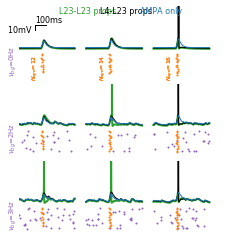

In [45]:
%run plots/plot_single_sim_bg_data.py
props = {'NSTIMs':[12,14,16],
         'alphaZn':[0., 0.45],
         'syn_location':1, 'stimseeds':[0], 'seeds':[0,0,0,0,1],
         'with_ampa_only':True,
         'LWS':[2,1,1], 'COLORS':[ge.green, 'k'],
         'LABELS':['L23-L23 props', 'L4-L23 props', 'AMPA only'],
         'bar_scale_args':dict(Xbar=100, Xbar_label='100ms', Ybar = 10, Ybar_label='10mV ', loc=(0.08,0.6), orientation='right-bottom'),
         'figsize':(1.8,.17), 'view':[-200,300], 'shift':100, 'VLIM':[-85,-0]}

fig = plot_single_sim_bg_data(RESP_ACTIVE, ge,
                              bg_levels=[0.,2,3], **props)
#fig.savefig(os.path.join('figures', 'bg-dep-active-full-example-single-trial.png'), dpi=300)
fig.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', 'C.svg'))

<Figure size 432x288 with 0 Axes>

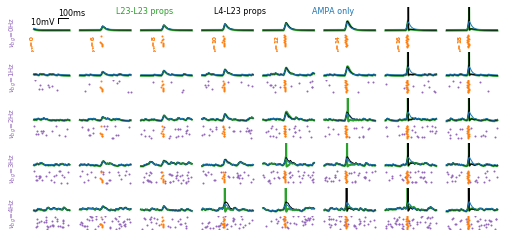

In [46]:
%run plots/plot_single_sim_bg_data.py
props = {'NSTIMs':None,
         'alphaZn':[0., 0.45],
         'syn_location':1, 'stimseeds':[0], 'seeds':[0,0,0,0,1],
         'with_ampa_only':True,
         'LWS':[2,1,1], 'COLORS':[ge.green, 'k'],
         'LABELS':['L23-L23 props', 'L4-L23 props', 'AMPA only'],
         'bar_scale_args':dict(Xbar=100, Xbar_label='100ms', Ybar = 10, Ybar_label='10mV ', loc=(0.08,0.6), orientation='right-bottom'),
         'figsize':(2.8,.1), 'view':[-200,300], 'shift':100, 'VLIM':[-85,-30]}

fig = plot_single_sim_bg_data(RESP_ACTIVE, ge,
                              bg_levels=[0.,1,2,3,4], **props)
fig.savefig(os.path.join('figures', 'bg-dep-active-full-example-single-trial.png'), dpi=300)

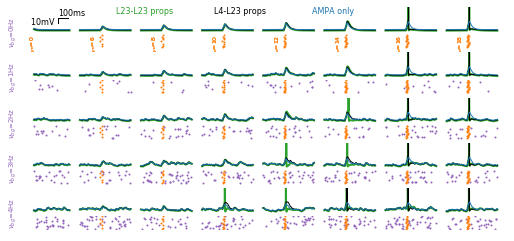

In [47]:
props['syn_location'] = 2
props['stimseeds'] = [1]
props['seeds'] = [0,0,0,0,1]
fig = plot_single_sim_bg_data(RESP_ACTIVE, ge,
                              bg_levels=[0.,1,2,3,4], **props)

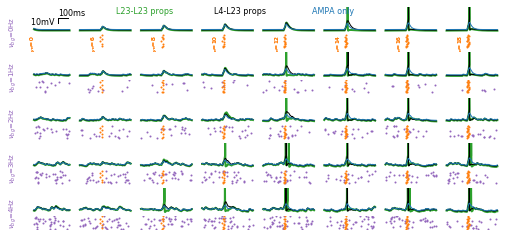

In [48]:
props['syn_location'] = 3
props['stimseeds'] = [1]
props['seeds'] = [3]
fig = plot_single_sim_bg_data(RESP_ACTIVE, ge,
                              bg_levels=[0.,1,2,3,4], **props)

#### shifting synaptic locations and seeds (background & stimulus)

In [49]:
%run bash/load_batch_simulations.py
RESP_ACTIVE_PER_STIM = build_full_dataset_per_stim(key='active',
                                    with_Vm_trace=True,
                                    folder = os.path.join('data', 'bg-modul'),
                                    filename_only=True)

<Figure size 432x288 with 0 Axes>

Text(0.5, 0.98, '\n                    syn loc. #5')

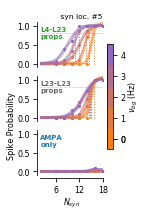

In [50]:
%run plots/show_trial_average_responses.py
props = {'syn_location':5, 'thresholds':{'Proba':0.8}} # 'VLIM':[-76,0], 

AMPA = get_trial_average_responses(RESP_ACTIVE_PER_STIM,
                                   'ampa-only', **props)
FREE = get_trial_average_responses(RESP_ACTIVE_PER_STIM,
                                   alphaZn=0.45, **props)
CHELATED = get_trial_average_responses(RESP_ACTIVE_PER_STIM,
                                       alphaZn=0., **props)
fig1 = show_response_bg_dep(FREE, CHELATED, AMPA, method='Proba', ge=ge,
                           ylim=[-0.1,1.1], xlim=[2,18],
                           crossing=props['thresholds']['Proba'])
fig1.suptitle('\n'+20*' '+'syn loc. #%i' % props['syn_location'], size=7.5)

Text(0.5, 0.98, '\n                    syn loc. #1')

<Figure size 432x288 with 0 Axes>

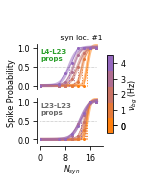

In [64]:
%run plots/show_trial_average_responses.py
props['syn_location'] = 1
FREE = get_trial_average_responses(RESP_ACTIVE_PER_STIM,
                                   alphaZn=0.45, **props)
CHELATED = get_trial_average_responses(RESP_ACTIVE_PER_STIM,
                                       alphaZn=0., **props)
fig = show_response_bg_dep(FREE, CHELATED, method='Proba', ge=ge,
                           ylim=[-0.1,1.1], xlim=[0,20],
                           crossing=props['thresholds']['Proba'])
fig.suptitle('\n'+20*' '+'syn loc. #%i' % props['syn_location'], size=7.5)

<Figure size 432x288 with 0 Axes>

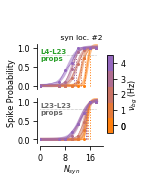

In [52]:
%run plots/show_trial_average_responses.py
props['syn_location'] = 2
FREE = get_trial_average_responses(RESP_ACTIVE_PER_STIM,
                                   alphaZn=0.45, **props)
CHELATED = get_trial_average_responses(RESP_ACTIVE_PER_STIM,
                                       alphaZn=0., **props)
fig2 = show_response_bg_dep(FREE, CHELATED, method='Proba', ge=ge,
                           ylim=[-0.1,1.1], xlim=[0,20],
                           crossing=props['thresholds']['Proba'])
fig2.suptitle('\n'+20*' '+'syn loc. #%i' % props['syn_location'], size=7.5);

Text(0.5, 0.98, '\n                    syn loc. #4')

<Figure size 432x288 with 0 Axes>

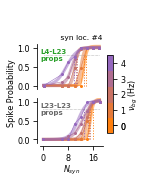

In [53]:
%run plots/show_trial_average_responses.py
props['syn_location'] = 4
FREE = get_trial_average_responses(RESP_ACTIVE_PER_STIM,
                                   alphaZn=0.45, **props)
CHELATED = get_trial_average_responses(RESP_ACTIVE_PER_STIM,
                                       alphaZn=0., **props)
fig = show_response_bg_dep(FREE, CHELATED, method='Proba', ge=ge,
                           ylim=[-0.1,1.1],
                           crossing=props['thresholds']['Proba'])
fig.suptitle('\n'+20*' '+'syn loc. #%i' % props['syn_location'], size=7.5)

Text(0.5, 0.98, '\n                    syn loc. #4')

<Figure size 432x288 with 0 Axes>

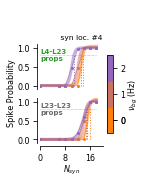

In [54]:
%run plots/show_trial_average_responses.py
props['syn_location'] = 4
FREE = get_trial_average_responses(RESP_ACTIVE_PER_STIM,
                                   alphaZn=0.45, **props)
CHELATED = get_trial_average_responses(RESP_ACTIVE_PER_STIM,
                                       alphaZn=0., **props)
fig = show_response_bg_dep(FREE, CHELATED, method='Proba', ge=ge,
                           ylim=[-0.1,1.1],
                           xlim=[0,20],
                           BG_levels=[0,1.,2],
                           crossing=props['thresholds']['Proba'])
fig.suptitle('\n'+20*' '+'syn loc. #%i' % props['syn_location'], size=7.5)

/home/yann/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yann/work/zinc-NMDA-modulation/plots/show_trial_average_responses.py:89: RuntimeWarning: invalid value encountered in greater
  RESP[ibg][key+'-threshold'] = np.array(x)[yf>thresholds[key]].min()


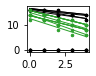

In [61]:
SLOPES = {'free':[], 'chelated':[]}
fig, ax= ge.figure()
for i in np.unique(RESP_PASSIVE_PER_STIM['syn_location']):
    props = {'syn_location':i, 'thresholds':{'Proba':0.5}}
    FREE=get_trial_average_responses(RESP_ACTIVE_PER_STIM, alphaZn=0.45, **props)
    CHELATED=get_trial_average_responses(RESP_ACTIVE_PER_STIM, alphaZn=0., **props)
    for C, color, key in zip([FREE, CHELATED],
                             ['k', ge.green], ['free', 'chelated']):
        x = [C[i]['bg_level'] for i in range(len(C))]
        y = [C[i]['Proba-threshold'] for i in range(len(C))]
        lin = np.polyfit(x, y, 1)
        SLOPES[key].append(-lin[0])
        ge.scatter(x, y, color=color, ax=ax, no_set=True)
        ge.plot(x, np.polyval(lin, x), color=color, ax=ax, no_set=True)

'0.4$\\pm$0.4, 1.5$\\pm$0.2'

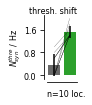

In [62]:
fig2, ax, pval = ge.related_samples_two_conditions_comparison(np.array(SLOPES['free']),
                                                                   np.array(SLOPES['chelated']),
                                                                   with_annotation=False,
                                                                   lw=.2,
                                                                   color1=ge.dimgrey, color2=ge.green,
                                                                   ylabel='$N_{syn}^{thre}$ / Hz',
                                                                   xticks=[],#[0, 1],
                                                                   fig_args=dict(right=4., figsize=(.7,1.4), left=1.2, top=2.5))
ge.annotate(ax, 'thresh. shift', (1., 1.), ha='right')
ge.annotate(ax, 'n=%i loc.' % len(SLOPES['free']) , (0, -.3))

'%.1f$\pm$%.1f, %.1f$\pm$%.1f' %(np.mean(SLOPES['free']), np.std(SLOPES['free']), np.mean(SLOPES['chelated']), np.std(SLOPES['chelated']))

In [63]:
from scipy.stats import wilcoxon
wilcoxon(np.array(SLOPES['free']),np.array(SLOPES['chelated']))

WilcoxonResult(statistic=0.0, pvalue=0.005005074402905223)

In [57]:
ge.multipanel_figure([[fig1, fig2]], LABELS=[['a', 'b']],
                     X=[[5, 150]], Y=[[-10, -30]],
                     X_LABELS=[[0, 160]], Y_LABELS=[[0, 0]],
                     width='single-column', export_to_png=True,
                     height=50, fig_name='figures/bg-dep-active.svg')

RUNNING: inkscape figures/bg-dep-active.svg --export-area-page --export-background="white" --export-type=png --export-filename="figures/bg-dep-active.png" --export-dpi=300
[ok] figure successfully exported as: figures/bg-dep-active.png


In [58]:
## Quantifying stimulus encoding (independently and across the background activity levels)

In [59]:
from sklearn.neighbors import NearestNeighbors

def build_training_set(RESP_PER_STIM, resp='L23',
                       stimseed='all',
                       N=None, # useless
                       bg_level='all',
                       syn_location='all',
                       verbose=True,
                       window=[-100, 300]):

    bg_level = 0
    
    if resp=='ampa-only':
        cond = (RESP_PER_STIM['ampa_only']==True)
    elif resp=='L23':
        cond = (RESP_PER_STIM['ampa_only']==False) & (RESP_PER_STIM['alphaZn']==0.45)
    elif resp=='L4':
        cond = (RESP_PER_STIM['ampa_only']==False) & (RESP_PER_STIM['alphaZn']==0.)
        
    if bg_level!='all':
        cond = cond & (RESP_PER_STIM['bg_level']==bg_level)
    if syn_location!='all':
        cond = cond & (RESP_PER_STIM['syn_location']==syn_location)
    if stimseed!='all':
        cond = cond & (RESP_PER_STIM['stimseed']==stimseed)
        
    nstims = np.unique(RESP_PER_STIM['nstim'][cond])

    Freq = []
    for i, nstim in enumerate(nstims):
        cond1 = cond & (RESP_PER_STIM['nstim']==nstim)
        Freq.append([np.mean(RESP_PER_STIM['spike'][cond1])])

    return Freq


def build_test_set(RESP_PER_STIM, resp='ampa-only',
                   N=100,
                   stimseed='all',
                   bg_level='all',
                   syn_location='all',
                   window=None, verbose=True):
    
    if resp=='ampa-only':
        cond = (RESP_PER_STIM['ampa_only']==True)
    elif resp=='L23':
        cond = (RESP_PER_STIM['ampa_only']==False) & (RESP_PER_STIM['alphaZn']==0.45)
    elif resp=='L4':
        cond = (RESP_PER_STIM['ampa_only']==False) & (RESP_PER_STIM['alphaZn']==0.)
        
    if stimseed!='all':
        cond = cond & (RESP_PER_STIM['stimseed']==stimseed)
    if bg_level!='all':
        cond = cond & (RESP_PER_STIM['bg_level']==bg_level)

    Freqs, true_ID = [], []
    
    syn_locations = np.unique(RESP_PER_STIM['syn_location'])
    nstims = np.sort(np.unique(RESP_PER_STIM['nstim'][cond]))
    i=0
    # we force that a single realisation has the sum of all location
    while i<N:
        ns = np.random.choice(nstims, 1) # we pick a given level
        freqs = []
        for s in syn_locations:
            cond1 = cond & (RESP_PER_STIM['syn_location']==s) & (RESP_PER_STIM['nstim']==ns)
            try:
                i0 = np.random.choice(np.arange(len(RESP_PER_STIM['nstim']))[cond1], 1)[0]
                freqs.append(RESP_PER_STIM['spike'][i0])
            except ValueError:
                pass
        
        true_ID.append(np.argwhere(ns==nstims)[0][0])
        Freqs.append([np.mean(freqs)])
        i+=1

    return Freqs, true_ID

def compute_decoding_accuracy(RESP_PER_STIM, props,
                              verbose=False):
    
    Freqs_training = build_training_set(RESP_PER_STIM, **props)

    nbrs = NearestNeighbors(n_neighbors=1,
                            algorithm='ball_tree').fit(Freqs_training)
    Freqs_test, test_ID = build_test_set(RESP_PER_STIM, **props)

    _, pred = nbrs.kneighbors(Freqs_test)
    val = test_ID-pred.flatten()
    if verbose:
        print('For the properties %s' % props)
        print('--> Decoder accuracy: %.2f %%    (chance level= %.0f%%)' % (100*np.sum(val==0)/len(val), 100/len(Freqs_training)))
    return 100*np.sum(val==0)/len(val)


props = {'bg_level':'all',
         'syn_location':'all',
         'stimseed':10,
         'resp':'L23',
         'window':[-100, 300],
         'N':200}
compute_decoding_accuracy(RESP_ACTIVE_PER_STIM, props, verbose=True)


For the properties {'bg_level': 'all', 'syn_location': 'all', 'stimseed': 10, 'resp': 'L23', 'window': [-100, 300], 'N': 200}
--> Decoder accuracy: 26.50 %    (chance level= 12%)


26.5

In [ ]:
props = {'bg_level':'all',
         'syn_location':'all',
         'resp':'L23',
         'window':[-100, 300],
         'N':1000}

fig4, ax = ge.figure(figsize=(1.,1),
                     left=0.6, bottom=0.3, top=0.6)
cmap = ge.get_linear_colormap(ge.orange, ge.purple)
stimseeds = np.unique(RESP_ACTIVE_PER_STIM['stimseed'])

for iax, color, resp, label in zip(range(2),
                            [ge.green, ge.dimgrey],
                            ['L4', 'L23'],
                            ['L4-L23 syn.', 'L23-L23 syn.']):
    props['resp'] = resp

    # start with all levels
    props['bg_level'] = 'all'
    X = []
    for ss in stimseeds:
        props['stimseed'] = ss
        try:
            x = compute_decoding_accuracy(RESP_ACTIVE_PER_STIM, props)
            X.append(x)
        except ValueError:
            pass

    ax.bar([iax], [np.mean(X)], yerr=[np.std(X)], width=.5, color=color)

    ge.annotate(ax, label, (iax/2.,1.+iax*.2), size='small', bold=True,
                color=color, ha='center')
    
ge.annotate(ax, 'chance level', (0.6, 10.),
            xycoords='data', va='top', size='small')
ax.plot([-0.25, 1.25], [10, 10], 'k--')

ge.set_plot(ax, ['left'],
            ylabel='PSPs-decoding\naccuracy (%)')